In [ ]:
!pip install datasets

## 导入包

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm

## 选择GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# 超参数

In [ ]:
MAX_LENGTH = 300       # 最大序列长度
EMBED_DIM = 200        # 嵌入维度
HIDDEN_DIM = 256       # LSTM隐藏层维度
NUM_LAYERS = 2         # LSTM层数
NUM_CLASSES = 2        # 二分类（正面/负面）
BATCH_SIZE = 32        # 批处理大小
NUM_EPOCHS = 10        # 训练轮数
LEARNING_RATE = 0.001  # 学习率
DROPOUT_RATE = 0.5     # 丢弃率

In [ ]:
# 使用Hugging Face的datasets库加载IMDB数据集
def load_imdb_dataset(max_samples=None):
    """
    使用Hugging Face的datasets库加载IMDB数据集

    参数:
        max_samples: 最大样本数（用于快速实验）
                    如果为None，则使用完整数据集

    返回:
        train_dataset: 训练数据集
        val_dataset: 验证数据集
        test_dataset: 测试数据集
    """
    print("加载IMDB数据集...")
    dataset = load_dataset("imdb")

    # 打印数据集信息
    print(f"数据集结构: {dataset}")
    print(f"数据集特征: {dataset['train'].features}")
    print(f"示例数据项: {dataset['train'][0]}")

    # 可选地限制样本数量以加快实验速度
    if max_samples:
        train_dataset = dataset["train"].shuffle(seed=42).select(range(min(max_samples, len(dataset["train"]))))
        test_dataset = dataset["test"].shuffle(seed=42).select(range(min(max_samples//2, len(dataset["test"]))))
    else:
        train_dataset = dataset["train"]
        test_dataset = dataset["test"]

    # 将训练集分割为训练集和验证集
    train_testvalid = train_dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = train_testvalid["train"]
    val_dataset = train_testvalid["test"]

    return train_dataset, val_dataset, test_dataset

In [ ]:
# Setup tokenizer using a pretrained model from Hugging Face
def setup_tokenizer(train_dataset):
    """
    Initialize a tokenizer based on a pretrained model from Hugging Face

    Args:
        train_dataset: Training dataset (unused but kept for consistency)

    Returns:
        tokenizer: Pretrained tokenizer
    """
    print("Setting up tokenizer...")

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    return tokenizer

## Tokenizer示例

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

example_text = "I love this series and binge-watched it throughout the week."

example_tokens = tokenizer(example_text, truncation=True, max_length=30, padding="max_length",)
print(f"tokenizer 输出类型 {type(example_tokens)}; 键 :{example_tokens.keys()}")
print(f"Tokenized `input_ids`: {example_tokens['input_ids']}")
print(f"Tokenized `attention_mask`: {example_tokens['attention_mask']}")

# 新增编码解码示例
# 将原始文本编码为token IDs
encoded_ids = tokenizer.encode(example_text)
print(f"\n编码后的token IDs: {encoded_ids}")

# 将token IDs解码回文本
decoded_text = tokenizer.decode(encoded_ids)
print(f"解码后的文本: {decoded_text}")

# 展示特殊token的处理
print("\n包含特殊token的完整编码解码过程:")
full_encoded = tokenizer.encode_plus(example_text, return_tensors="pt")
print(f"完整编码结果: {full_encoded}")
full_decoded = tokenizer.decode(full_encoded["input_ids"][0])
print(f"完整解码结果: {full_decoded}")

tokenizer 输出类型 <class 'transformers.tokenization_utils_base.BatchEncoding'>; 键 :dict_keys(['input_ids', 'attention_mask'])
Tokenized `input_ids`: [101, 1045, 2293, 2023, 2186, 1998, 17620, 2063, 1011, 3427, 2009, 2802, 1996, 2733, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenized `attention_mask`: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

编码后的token IDs: [101, 1045, 2293, 2023, 2186, 1998, 17620, 2063, 1011, 3427, 2009, 2802, 1996, 2733, 1012, 102]
解码后的文本: [CLS] i love this series and binge - watched it throughout the week. [SEP]

包含特殊token的完整编码解码过程:
完整编码结果: {'input_ids': tensor([[  101,  1045,  2293,  2023,  2186,  1998, 17620,  2063,  1011,  3427,
          2009,  2802,  1996,  2733,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
完整解码结果: [CLS] i love this series and binge - watched it throughout the week. [SEP]


In [ ]:
# 通过tokenize文本来预处理数据集
def preprocess_dataset(dataset, tokenizer, max_length=MAX_LENGTH):
    """
    使用提供的tokenizer对数据集进行tokenize处理

    参数:
        dataset: 需要预处理的数据集
        tokenizer: 使用的tokenizer
        max_length: 最大序列长度

    返回:
        tokenized_dataset: 经过预处理并tokenize后的数据集
    """
    print(f"Preprocessing dataset...")

    def tokenize_function(examples):
        """对一批样本进行tokenize处理"""
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )

    # 对整个数据集应用tokenize处理
    # 使用批处理方式提高效率
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["text"]
    )

    # 将'label'列重命名为'labels'以适配某些HF模型的要求
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

    # 设置输出格式为PyTorch张量
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    print(f"Dataset after preprocessing: {tokenized_dataset}")
    return tokenized_dataset

In [ ]:
# LSTM模型定义
class TextLSTM(nn.Module):
    """
    用于文本分类的LSTM模型

    特性:
    - 嵌入层将token ID转换为向量
    - 双向LSTM可以从两个方向捕获上下文信息
    - 两种池化选项:
      1. 最后token池化：使用最后一个token的隐藏状态
      2. 平均池化：对所有非填充token的表示取平均
    - 批归一化使训练更稳定
    - Dropout用于正则化

    平均池化通常能从整个序列中捕获更多信息，
    而最后一个token可能由于其最终位置而包含更多与情感相关的信息。
    根据数据集和任务的不同，不同的池化方法可能导致不同的性能表现。
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5, use_mean_pooling=False):
        super(TextLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.use_mean_pooling = use_mean_pooling

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # 批归一化层
        self.bn = nn.BatchNorm1d(hidden_dim * 2)

        # 最终分类层
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, attention_mask=None):
        """
        模型的前向传播

        参数:
            x: token索引的输入张量 [batch_size, seq_length]
            attention_mask: 指示哪些token是填充(0)哪些是真实token(1)的掩码

        返回:
            output: 模型预测结果 [batch_size, num_classes]
        """
        # 输入形状: [batch_size, seq_length]
        embedded = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        embedded = self.dropout(embedded)

        # 应用LSTM
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_length, hidden_dim*2]

        if self.use_mean_pooling:
            # 对所有非填充token进行平均池化
            # 这种方法通常能从整个序列中捕获更多全局信息
            if attention_mask is not None:
                # 创建扩展后的掩码以便正确广播
                # 形状: [batch_size, seq_length, 1]
                expanded_mask = attention_mask.unsqueeze(-1).float()

                # 应用掩码并仅对真实token计算均值
                # 这确保填充token不会影响平均值

                # 1. 将LSTM输出与掩码相乘，将填充token置零
                # lstm_out: [batch_size, seq_length, hidden_dim*2]
                # expanded_mask: [batch_size, seq_length, 1]
                # masked_output: [batch_size, seq_length, hidden_dim*2]
                # 其中填充token的值将被置零

                # 2. 对所有隐藏状态求和
                sum_hidden = torch.sum(lstm_out * expanded_mask, dim=1)

                # 3. 计算每个序列中真实token(非填充)的数量
                token_count = torch.sum(attention_mask, dim=1, keepdim=True).float()

                # 4. 避免除以零(虽然不应该发生，但为了安全)
                token_count = torch.clamp(token_count, min=1.0)

                # 5. 计算均值: 隐藏状态的和 / 数量
                pooled_output = sum_hidden / token_count
            else:
                # 如果没有提供掩码，则对所有token取平均
                pooled_output = torch.mean(lstm_out, dim=1)
        else:
            # 最后token池化
            # 对于分类任务效果通常较好，因为最后一个token可能包含重要的决策信息
            if attention_mask is not None:
                # 获取每个序列中最后一个token的索引
                last_idx = attention_mask.sum(dim=1) - 1
                batch_size = lstm_out.size(0)

                # 获取每个序列最后一个token的隐藏状态
                pooled_output = lstm_out[torch.arange(batch_size), last_idx]
            else:
                # 如果没有注意力掩码，直接使用最后一个token的隐藏状态
                pooled_output = lstm_out[:, -1, :]

        # # 应用批归一化
        # normed = self.bn(pooled_output)

        # 应用dropout和最后的线性层
        out = self.dropout(pooled_output)
        out = self.fc(out)

        return out


### 为什么LSTM里面batch不是第一个维度？

- https://discuss.pytorch.org/t/what-is-the-reason-of-rnns-batch-first-parameter-is-set-false-as-default/94333
- https://stackoverflow.com/questions/65451265/pytorch-why-batch-is-the-second-dimension-in-the-default-lstm

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_dir='models'):
    """
        参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 训练设备
        save_dir: 模型检查点保存目录

    返回:
        history: 用于记录训练历史的字典
    """

    import os
    os.makedirs(save_dir, exist_ok=True)

    best_val_acc = 0

    # 追踪训练过程
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 前馈过程
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # 反向传播和参数更新
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()

            total_loss += loss.item()

            # 记录预测结果，准备后续计算准确率
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # 在训练集上计算指标
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds) * 100

        # 验证阶段
        model.eval()
        val_loss = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        # 在验证集上计算指标
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds) * 100

        # 更新历史记录
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # 保存最好的模型

        if not model.use_mean_pooling:
          model_name = model.__class__.__name__
        else:
          model_name = model.__class__.__name__ + "_mean"

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, os.path.join(save_dir, f'best_{model_name}.pth'))

    # 绘制训练历史曲线图
    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_curves.png'))
    plt.show()

    return history

In [ ]:
# 评估函数
def evaluate_model(model, test_loader, criterion, device):
    """
        参数:
        model: 待评估的模型
        test_loader: 测试数据加载器
        criterion: 损失函数
        device: 评估使用的设备

    返回:
        test_loss: 测试集损失值
        test_acc: 测试集准确率
        all_preds: 所有预测结果
        all_labels: 所有真实标签
    """

    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算指标
    test_loss = total_loss / len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds) * 100

    # 打印详细的分类报告
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

    return test_loss, test_acc, all_preds, all_labels

In [ ]:
# 预测新样本的情感
def predict_sentiment(model, tokenizer, texts, device):
    """
        参数:
        model: 训练好的模型
        tokenizer: 分词器
        texts: 待预测的文本列表
        device: 预测使用的设备

    返回:
        results: (情感标签, 置信度) 元组列表
    """
    model.eval()

    # Tokenize文本
    encoded_texts = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    input_ids = encoded_texts['input_ids'].to(device)
    attention_mask = encoded_texts['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)

    results = []
    for i, text in enumerate(texts):
        sentiment = "Positive" if predictions[i].item() == 1 else "Negative"
        confidence = probabilities[i][predictions[i]].item()
        results.append((sentiment, confidence))

    return results

In [ ]:
def main(max_samples=None, use_mean_pooling=False):
    """
      运行整个流程的主函数

      参数:
          max_samples: 使用的最大样本数量
          use_mean_pooling: 池化方式选择
              - True: 对所有非填充token进行平均池化
              - False: 使用最后一个token的表征
      返回:
          None
    """
    # 加载模型
    train_dataset, val_dataset, test_dataset = load_imdb_dataset(max_samples)
    print(f"Dataset loaded: {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples")

    # 初始化tokenizer
    tokenizer = setup_tokenizer(train_dataset)

    # 数据预处理
    train_tokenized = preprocess_dataset(train_dataset, tokenizer, MAX_LENGTH)
    val_tokenized = preprocess_dataset(val_dataset, tokenizer, MAX_LENGTH)
    test_tokenized = preprocess_dataset(test_dataset, tokenizer, MAX_LENGTH)

    # 创建数据加载器
    train_loader = DataLoader(train_tokenized, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_tokenized, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_tokenized, batch_size=BATCH_SIZE, shuffle=False)

    # 获取词表大小
    vocab_size = tokenizer.vocab_size
    print(f"Vocabulary size: {vocab_size}")

    # 模型实例化
    pooling_method = "mean pooling" if use_mean_pooling else "last token"
    print(f"Using {pooling_method} for sequence representation")

    model = TextLSTM(
        vocab_size=vocab_size,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=NUM_CLASSES,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT_RATE,
        use_mean_pooling=use_mean_pooling
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练模型
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        NUM_EPOCHS,
        device
    )

    # 加载最佳模型用于测试
    model_name = "TextLSTM_mean" if use_mean_pooling else "TextLSTM"
    checkpoint = torch.load(f'models/best_{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 评估模型在测试集上的表现
    test_loss, test_acc, _, _ = evaluate_model(model, test_loader, criterion, device)
    print(f"\nTest Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    # 测试用例
    test_texts = [
        "This movie was absolutely fantastic! I loved every minute of it.",
        "I really didn't enjoy this film. It was boring and predictable.",
        "The acting was great, but the plot was a bit confusing."
    ]

    print("\nSample Predictions:")
    predictions = predict_sentiment(model, tokenizer, test_texts, device)

    for i, (text, (sentiment, confidence)) in enumerate(zip(test_texts, predictions)):
        print(f"\nText: {text}")
        print(f"Prediction: {sentiment} (confidence: {confidence:.2f})")

加载IMDB数据集...


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

数据集结构: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
数据集特征: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
示例数据项: {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certai

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Dataset after preprocessing: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 800
})
Preprocessing dataset...


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset after preprocessing: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})
Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset after preprocessing: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 500
})
Vocabulary size: 30522
Using mean pooling for sequence representation
Starting training for 10 epochs...


Epoch 1/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.6927, Train Acc: 52.00%, Val Loss: 0.6776, Val Acc: 61.00%


Epoch 2/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6661, Train Acc: 63.25%, Val Loss: 0.5884, Val Acc: 70.00%


Epoch 3/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.6075, Train Acc: 69.88%, Val Loss: 0.7595, Val Acc: 64.50%


Epoch 4/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5055, Train Acc: 74.88%, Val Loss: 0.6231, Val Acc: 70.50%


Epoch 5/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.4514, Train Acc: 79.50%, Val Loss: 0.6196, Val Acc: 73.50%


Epoch 6/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.4140, Train Acc: 80.25%, Val Loss: 0.6296, Val Acc: 69.50%


Epoch 7/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3047, Train Acc: 87.88%, Val Loss: 0.6810, Val Acc: 75.50%


Epoch 8/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.2107, Train Acc: 91.62%, Val Loss: 0.6537, Val Acc: 74.50%


Epoch 9/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.1915, Train Acc: 93.12%, Val Loss: 0.8576, Val Acc: 76.50%


Epoch 10/10 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.1401, Train Acc: 94.50%, Val Loss: 1.2209, Val Acc: 72.00%


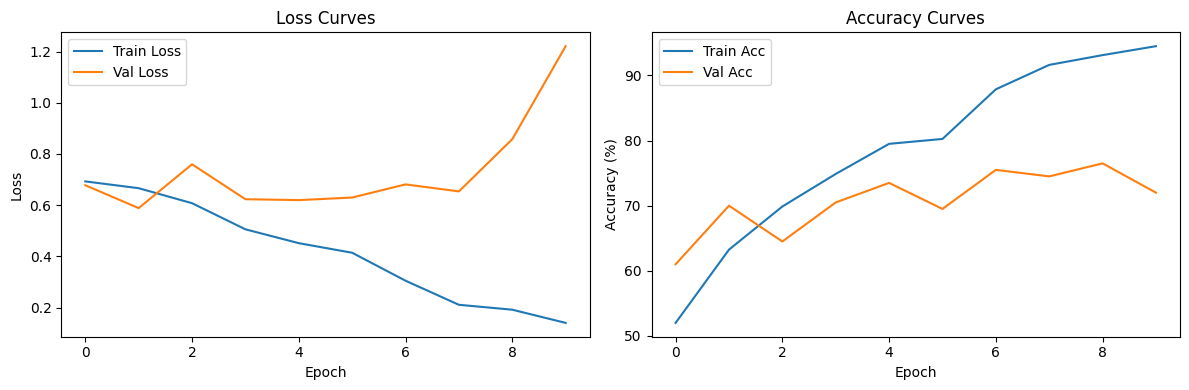

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.60      0.68       254
    Positive       0.66      0.81      0.73       246

    accuracy                           0.71       500
   macro avg       0.72      0.71      0.70       500
weighted avg       0.72      0.71      0.70       500


Test Results: Loss: 1.0546, Accuracy: 70.60%

Sample Predictions:

Text: This movie was absolutely fantastic! I loved every minute of it.
Prediction: Positive (confidence: 1.00)

Text: I really didn't enjoy this film. It was boring and predictable.
Prediction: Negative (confidence: 0.85)

Text: The acting was great, but the plot was a bit confusing.
Prediction: Positive (confidence: 1.00)


In [ ]:
# 使用部分数据集来测试代码
main(max_samples=1000, use_mean_pooling=True)  # 每一类的数量是 max_samples / 2